# Cryptocurrency Trader Agent

### UCB MIDS 2017 Winter Capstone Project
#### Ramsey Aweti, Shuang Chan, GuangZhi(Frank) Xie, Jason Xie

### Global Variables

In [1]:
import random 
random.seed(3456)

In [9]:
num_coins_per_order = 100 #0 means buy/sell all per order
recent_k = 500
epsilon_min = 0.0

External States: ["current_price", "rolling_mean", "rolling_std", "cross_upper_band", "cross_lower_band", "upper_band", "lower_band", "price_over_sma"]

Internal States: ["coin", "cash", "total_value", "is_holding_coin", "return_since_entry"]

## ETH

In [10]:
coin_name = 'ethereum'

### Benchmarks

In [11]:
from v2 import run_benchmarks

In [12]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 36119.16 cash, 36119.16 current value, 52.62 percent returns


52.624918076289724

In [13]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 400.00 coins, 1886747.94 cash, 2004981.66 current value, 20.14 percent returns


20.137932070887192

In [14]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 50000.00 coins, 0.00 cash, 14779215.00 current value, 165.97 percent returns


165.96789745613376

### DDQN Agent

In [5]:
from v2.ddqn_agent import DDQNAgent

Using TensorFlow backend.


In [6]:
eth_agent = DDQNAgent(coin_name=coin_name, recent_k = 500, num_coins_per_order = num_coins_per_order, 
                      epsilon_min = epsilon_min,
                      external_states = ["current_price", "cross_upper_band", "cross_lower_band"],
                      internal_states = ["is_holding_coin"], verbose = False)

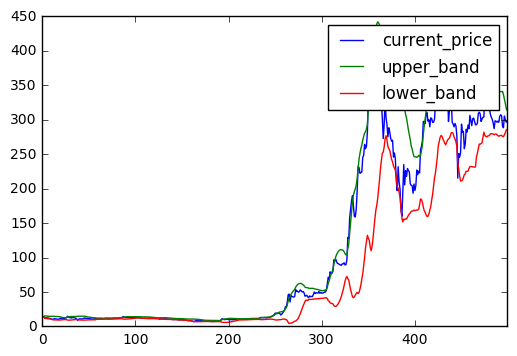

In [7]:
eth_agent.plot_env(states_to_plot=["current_price", "upper_band", "lower_band"])

In [8]:
eth_agent.train(num_episodes=800)

episode: 1/800, returns: 3.13650891877, epsilon: 1.0
episode: 2/800, returns: 13.9780592183, epsilon: 0.99
episode: 3/800, returns: 35.0632165734, epsilon: 0.99
episode: 4/800, returns: 4.10410425427, epsilon: 0.99
episode: 5/800, returns: 22.0787548688, epsilon: 0.98
episode: 6/800, returns: -0.93205007141, epsilon: 0.98
episode: 7/800, returns: 48.0989443579, epsilon: 0.97
episode: 8/800, returns: 9.6306680707, epsilon: 0.97
episode: 9/800, returns: 18.0819750714, epsilon: 0.96
episode: 10/800, returns: 12.0934758735, epsilon: 0.96
episode: 11/800, returns: 6.64952590699, epsilon: 0.95
episode: 12/800, returns: 6.29239547242, epsilon: 0.95
episode: 13/800, returns: 23.2392590594, epsilon: 0.94
episode: 14/800, returns: 45.6503649636, epsilon: 0.94
episode: 15/800, returns: -0.659298738438, epsilon: 0.93
episode: 16/800, returns: 1.76709581238, epsilon: 0.93
episode: 17/800, returns: 9.21717650809, epsilon: 0.92
episode: 18/800, returns: 9.0185040608, epsilon: 0.92
episode: 19/800, re

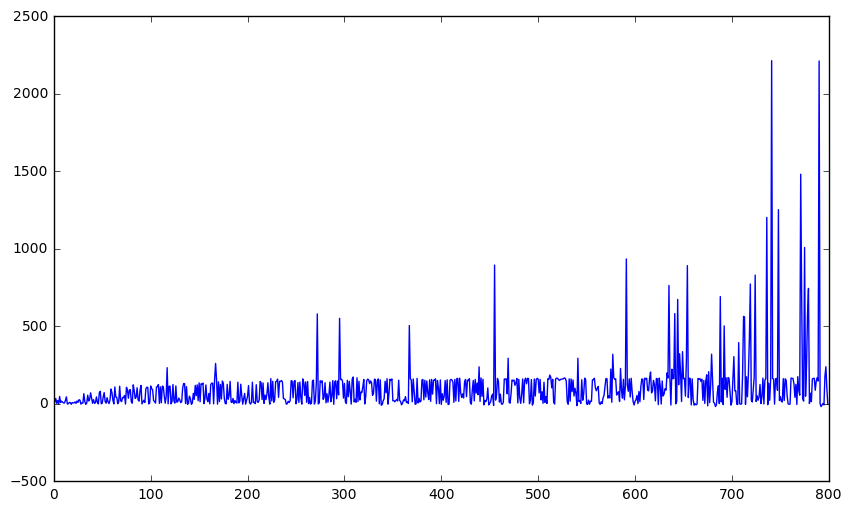

In [15]:
eth_agent.plot_cum_returns()

In [18]:
eth_agent.test(epsilon=0.018)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Acti

## Numeraire

In [19]:
coin_name = 'numeraire'

### Benchmarks

In [20]:
from v2 import run_benchmarks

In [21]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 400.00 coins, 0.00 cash, 4264.92 current value, -35.86 percent returns


-35.864321547586101

In [22]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 500.00 coins, 70700.85 cash, 76032.00 current value, -9.08 percent returns


-9.0786898874437014

In [23]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 13800.00 coins, 0.00 cash, 147139.74 current value, -58.12 percent returns


-58.120126001888984

### DDQN Agent

In [24]:
from v2.ddqn_agent import DDQNAgent

In [25]:
numeraire_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, 
                            epsilon_min = epsilon_min,
                            external_states = ["cross_upper_band", "cross_lower_band", "current_price"],
                            internal_states = ["is_holding_coin"])

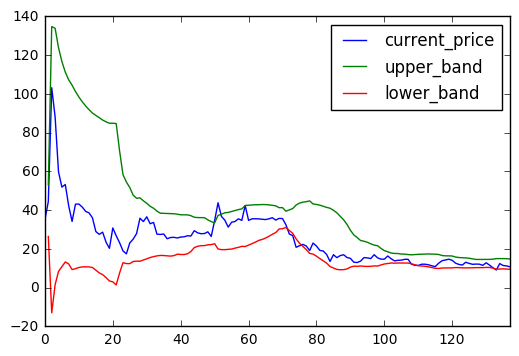

In [26]:
numeraire_agent.plot_env(states_to_plot=["current_price", "upper_band", "lower_band"])

In [27]:
numeraire_agent.train(num_episodes=800)

episode: 1/800, returns: -21.4168831926, epsilon: 1.0
episode: 2/800, returns: -3.95075644049, epsilon: 0.99
episode: 3/800, returns: -21.24413729, epsilon: 0.99
episode: 4/800, returns: -9.8085826845, epsilon: 0.99
episode: 5/800, returns: -10.1484366206, epsilon: 0.98
episode: 6/800, returns: -2.73809612635, epsilon: 0.98
episode: 7/800, returns: 12.3903014258, epsilon: 0.97
episode: 8/800, returns: -8.5578382903, epsilon: 0.97
episode: 9/800, returns: -30.1917265679, epsilon: 0.96
episode: 10/800, returns: -12.7295815083, epsilon: 0.96
episode: 11/800, returns: -16.610861658, epsilon: 0.95
episode: 12/800, returns: -33.3643449438, epsilon: 0.95
episode: 13/800, returns: -7.65377067441, epsilon: 0.94
episode: 14/800, returns: -1.93389169573, epsilon: 0.94
episode: 15/800, returns: 1.61442152969, epsilon: 0.93
episode: 16/800, returns: -32.872902008, epsilon: 0.93
episode: 17/800, returns: -19.0584837745, epsilon: 0.92
episode: 18/800, returns: -5.71328694436, epsilon: 0.92
episode: 1

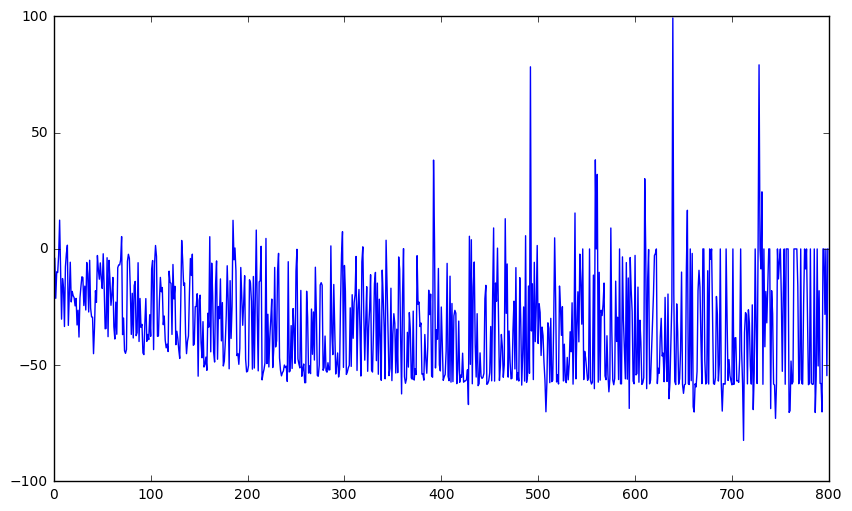

In [28]:
numeraire_agent.plot_cum_returns()

In [31]:
numeraire_agent.test(epsilon=epsilon_min)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Acti

## Qtum

In [32]:
coin_name = 'qtum'

### Benchmarks

In [33]:
from v2 import run_benchmarks

In [34]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 100.00 coins, 2578.95 cash, 3600.63 current value, 86.16 percent returns


86.160845849598033

In [35]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 300.00 coins, 53493.66 cash, 56558.70 current value, 1.37 percent returns


1.3679794205368181

In [36]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 16800.00 coins, 0.00 cash, 171642.24 current value, -2.85 percent returns


-2.8515175233731833

### DDQN Agent

In [37]:
from v2.ddqn_agent import DDQNAgent

In [39]:
qtum_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, 
                       epsilon_min = epsilon_min,
                       external_states = ["current_price", "cross_upper_band", "cross_lower_band"],
                       internal_states = ["is_holding_coin"])

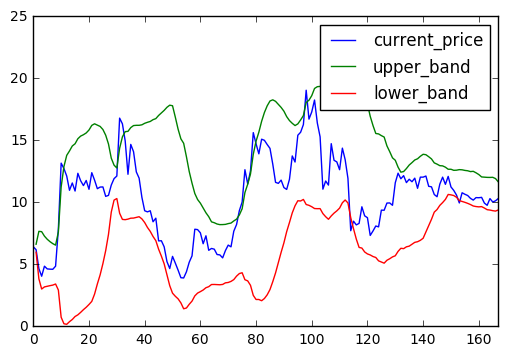

In [40]:
qtum_agent.plot_env(states_to_plot=["current_price", "upper_band", "lower_band"])

In [41]:
qtum_agent.train(num_episodes=800)

episode: 1/800, returns: -2.29011064868, epsilon: 1.0
episode: 2/800, returns: -6.45613679051, epsilon: 0.99
episode: 3/800, returns: -7.00238628514, epsilon: 0.99
episode: 4/800, returns: -2.39822800239, epsilon: 0.99
episode: 5/800, returns: -2.69652034759, epsilon: 0.98
episode: 6/800, returns: 0.790406072399, epsilon: 0.98
episode: 7/800, returns: 1.60974599484, epsilon: 0.97
episode: 8/800, returns: -7.16297312869, epsilon: 0.97
episode: 9/800, returns: -9.06693930263, epsilon: 0.96
episode: 10/800, returns: -2.68453518307, epsilon: 0.96
episode: 11/800, returns: -6.77733332643, epsilon: 0.95
episode: 12/800, returns: 3.121326164, epsilon: 0.95
episode: 13/800, returns: 0.551461393601, epsilon: 0.94
episode: 14/800, returns: -8.50412380604, epsilon: 0.94
episode: 15/800, returns: 4.52397547424, epsilon: 0.93
episode: 16/800, returns: 8.77551326449, epsilon: 0.93
episode: 17/800, returns: -0.829150962433, epsilon: 0.92
episode: 18/800, returns: -3.03565590613, epsilon: 0.92
episode

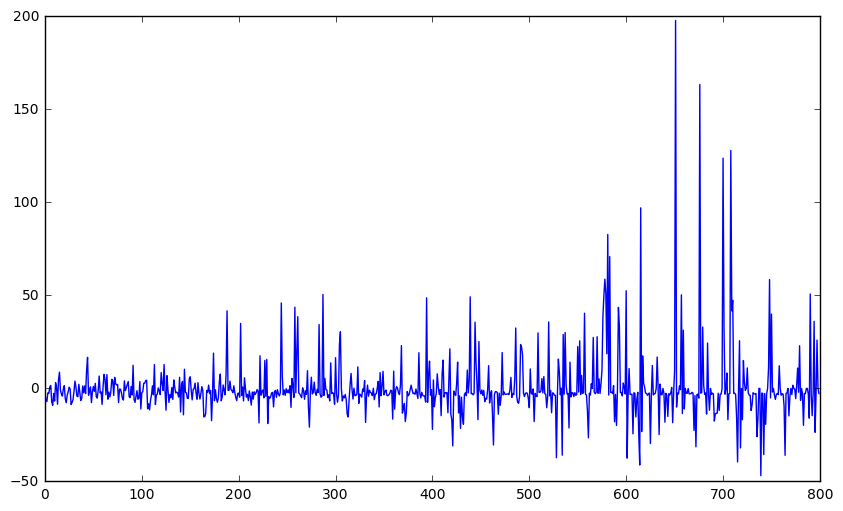

In [42]:
qtum_agent.plot_cum_returns()

In [44]:
qtum_agent.test(epsilon=0.018)

Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY

## Ripple

In [45]:
coin_name = 'ripple'

### Benchmarks

In [46]:
from v2 import run_benchmarks

In [47]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 53.22 cash, 53.22 current value, 58.58 percent returns


58.579309099075815

In [48]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 800.00 coins, 1245.57 cash, 1408.01 current value, 4.69 percent returns


4.6913070582546892

In [49]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 50000.00 coins, 0.00 cash, 10152.60 current value, 124.32 percent returns


124.31982874818192

### DDQN Agent

In [50]:
from v2.ddqn_agent import DDQNAgent

In [51]:
ripple_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, 
                       epsilon_min = epsilon_min,
                       external_states = ["current_price", "cross_upper_band", "cross_lower_band"],
                       internal_states = ["is_holding_coin"])

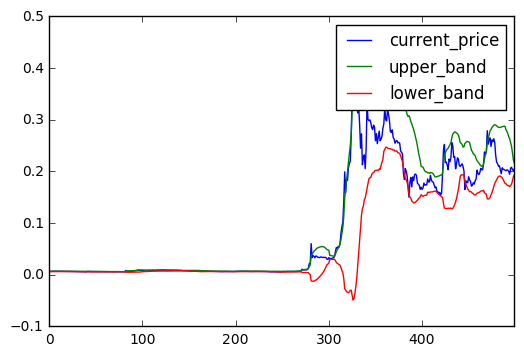

In [52]:
ripple_agent.plot_env(states_to_plot=["current_price", "upper_band", "lower_band"])

In [53]:
ripple_agent.train(num_episodes=800)

episode: 1/800, returns: 2.11086595825, epsilon: 1.0
episode: 2/800, returns: 5.02788535578, epsilon: 0.99
episode: 3/800, returns: -5.43584870509, epsilon: 0.99
episode: 4/800, returns: 10.5497455293, epsilon: 0.99
episode: 5/800, returns: -0.199469959898, epsilon: 0.98
episode: 6/800, returns: 15.337162114, epsilon: 0.98
episode: 7/800, returns: 23.3632575402, epsilon: 0.97
episode: 8/800, returns: 18.7914940012, epsilon: 0.97
episode: 9/800, returns: -5.20713615298, epsilon: 0.96
episode: 10/800, returns: -2.657917302, epsilon: 0.96
episode: 11/800, returns: 44.6337661028, epsilon: 0.95
episode: 12/800, returns: -3.28219596506, epsilon: 0.95
episode: 13/800, returns: 33.3736450495, epsilon: 0.94
episode: 14/800, returns: 28.4204374681, epsilon: 0.94
episode: 15/800, returns: 12.6570746226, epsilon: 0.93
episode: 16/800, returns: 15.8531676989, epsilon: 0.93
episode: 17/800, returns: 5.0380307182, epsilon: 0.92
episode: 18/800, returns: 41.8146781692, epsilon: 0.92
episode: 19/800, r

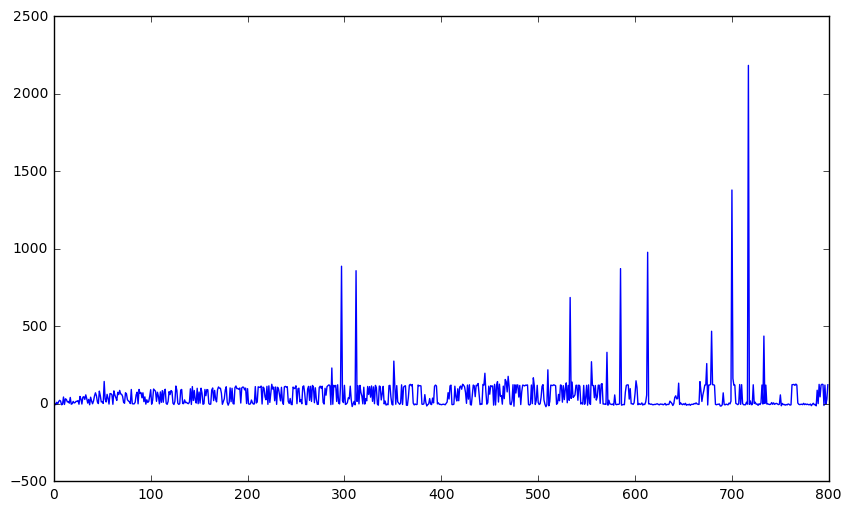

In [54]:
ripple_agent.plot_cum_returns()

In [55]:
ripple_agent.test(epsilon=0.018)

Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.BUY
Action.HOL

## Bitcoin

In [56]:
coin_name = 'bitcoin'

### Benchmarks

In [57]:
from v2 import run_benchmarks

In [58]:
run_benchmarks.run_bollingerband_agent(
    coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 0.00 coins, 116092.35 cash, 116092.35 current value, 8.91 percent returns


8.9134710355511189

In [59]:
run_benchmarks.run_random_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 300.00 coins, 29780573.13 cash, 31866433.83 current value, 6.50 percent returns


6.5045344425180067

In [60]:
run_benchmarks.run_alwaysbuy_agent(coin_name=coin_name, num_coins_per_order = num_coins_per_order, recent_k=recent_k)

Final holdings: 50000.00 coins, 0.00 cash, 347643450.00 current value, 272.27 percent returns


272.27132652478878

### DDQN Agent

In [61]:
from v2.ddqn_agent import DDQNAgent

In [62]:
btc_agent = DDQNAgent(coin_name=coin_name, recent_k = recent_k, num_coins_per_order = num_coins_per_order, 
                       epsilon_min = epsilon_min,
                       external_states = ["current_price", "cross_upper_band", "cross_lower_band"],
                       internal_states = ["is_holding_coin"])

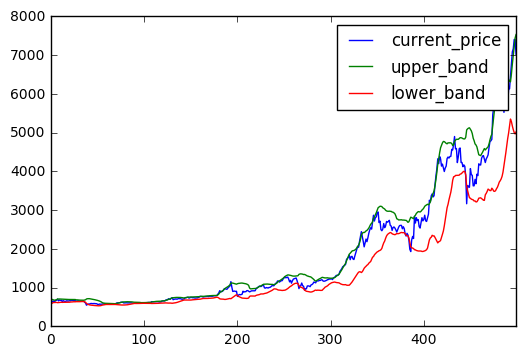

In [63]:
btc_agent.plot_env(states_to_plot=["current_price", "upper_band", "lower_band"])

In [64]:
btc_agent.train(num_episodes=800)

episode: 1/800, returns: 57.3024946604, epsilon: 1.0
episode: 2/800, returns: 59.0053948411, epsilon: 0.99
episode: 3/800, returns: 5.98876650024, epsilon: 0.99
episode: 4/800, returns: 5.5340194633, epsilon: 0.99
episode: 5/800, returns: 38.9914389254, epsilon: 0.98
episode: 6/800, returns: 15.1001180397, epsilon: 0.98
episode: 7/800, returns: 26.9014707504, epsilon: 0.97
episode: 8/800, returns: 6.84399833882, epsilon: 0.97
episode: 9/800, returns: 58.7434164933, epsilon: 0.96
episode: 10/800, returns: 62.7785785822, epsilon: 0.96
episode: 11/800, returns: 14.827157074, epsilon: 0.95
episode: 12/800, returns: 6.38596534934, epsilon: 0.95
episode: 13/800, returns: 6.04640493295, epsilon: 0.94
episode: 14/800, returns: 33.4627878958, epsilon: 0.94
episode: 15/800, returns: 57.4094202004, epsilon: 0.93
episode: 16/800, returns: 10.1108997401, epsilon: 0.93
episode: 17/800, returns: 10.3966198204, epsilon: 0.92
episode: 18/800, returns: 90.8147166268, epsilon: 0.92
episode: 19/800, retur

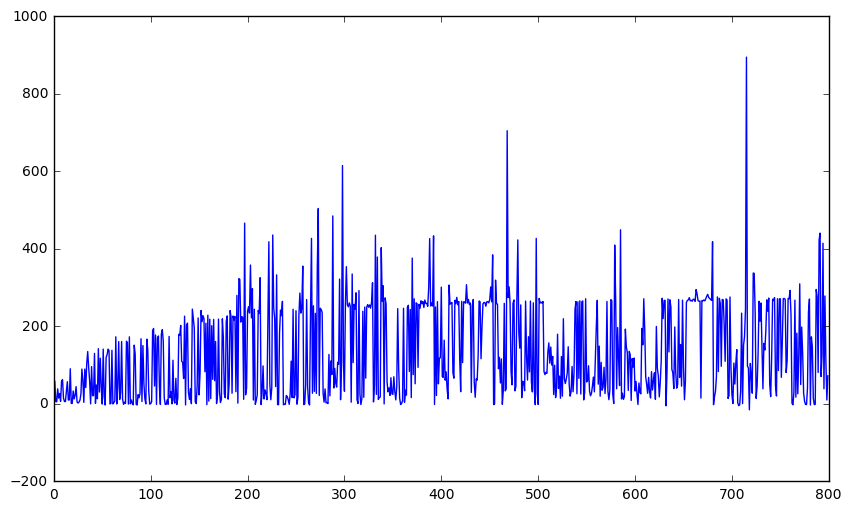

In [66]:
btc_agent.plot_cum_returns()

In [67]:
btc_agent.test(epsilon=0.018)

Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.BUY
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Action.HOLD
Actio